## We look into Opyn squeeth crab strategy V1, finding how are hedge performed and what we can do 

Some Context: SQTH works on ETH^2 where funding (normalisation factor) are pay in kind, so price of SQTH reduce, making debt cheaper to repay. this is based on the normalisation factor where fundings = (old norm)1- (new norm)0.99 = 1% funding. long pays short.

so from a short side, u dont receive fundings in cash but since normalisation factor diminish u should be able to mint more sqth and sell it for eth or simply remove eth to keep collateralisation level.


Crab strategy V1 is a vault for shorting vol while remains a delta neutral position. it rebalances daily or when price threshold are met.

If ETH moves more than an amount that is based on the funding received from the short Squeeth position (approximately 6% in either direction in a single day, subject to volatility) the strategy is unprofitable. (https://opyn.gitbook.io/squeeth/resources/squeeth-strategies-faq)




## Before going into details we look at greeks for sqth


In [3]:
import web3
import json
import requests
import subprocess
import time
import os
from dotenv import load_dotenv

config= load_dotenv()

INFURA = os.getenv('INFURA')

CRAB_ADDRESS = "0xf205ad80BB86ac92247638914265887A8BAa437D"
CRAB_ABI= '[{"inputs":[{"internalType":"address","name":"_wSqueethController","type":"address"},{"internalType":"address","name":"_oracle","type":"address"},{"internalType":"address","name":"_weth","type":"address"},{"internalType":"address","name":"_uniswapFactory","type":"address"},{"internalType":"address","name":"_ethWSqueethPool","type":"address"},{"internalType":"uint256","name":"_hedgeTimeThreshold","type":"uint256"},{"internalType":"uint256","name":"_hedgePriceThreshold","type":"uint256"},{"internalType":"uint256","name":"_auctionTime","type":"uint256"},{"internalType":"uint256","name":"_minPriceMultiplier","type":"uint256"},{"internalType":"uint256","name":"_maxPriceMultiplier","type":"uint256"}],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"depositor","type":"address"},{"indexed":false,"internalType":"uint256","name":"wSqueethAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"lpAmount","type":"uint256"}],"name":"Deposit","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"seller","type":"address"},{"indexed":false,"internalType":"uint256","name":"wSqueethBought","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"ethSold","type":"uint256"},{"indexed":false,"internalType":"bool","name":"isHedgingOnUniswap","type":"bool"}],"name":"ExecuteBuyAuction","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"buyer","type":"address"},{"indexed":false,"internalType":"uint256","name":"wSqueethSold","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"ethBought","type":"uint256"},{"indexed":false,"internalType":"bool","name":"isHedgingOnUniswap","type":"bool"}],"name":"ExecuteSellAuction","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"depositor","type":"address"},{"indexed":false,"internalType":"uint256","name":"depositedAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"tradedAmountOut","type":"uint256"}],"name":"FlashDeposit","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"depositor","type":"address"},{"indexed":false,"internalType":"uint256","name":"flashswapDebt","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"excess","type":"uint256"}],"name":"FlashDepositCallback","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"withdrawer","type":"address"},{"indexed":false,"internalType":"uint256","name":"crabAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"wSqueethAmount","type":"uint256"}],"name":"FlashWithdraw","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"withdrawer","type":"address"},{"indexed":false,"internalType":"uint256","name":"flashswapDebt","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"excess","type":"uint256"}],"name":"FlashWithdrawCallback","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"hedger","type":"address"},{"indexed":false,"internalType":"bool","name":"auctionType","type":"bool"},{"indexed":false,"internalType":"uint256","name":"hedgerPrice","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"auctionPrice","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"wSqueethHedgeTargetAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"ethHedgetargetAmount","type":"uint256"}],"name":"Hedge","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"hedger","type":"address"},{"indexed":false,"internalType":"bool","name":"auctionType","type":"bool"},{"indexed":false,"internalType":"uint256","name":"auctionPrice","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"wSqueethHedgeTargetAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"ethHedgetargetAmount","type":"uint256"}],"name":"HedgeOnUniswap","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"hedger","type":"address"},{"indexed":false,"internalType":"bool","name":"auctionType","type":"bool"},{"indexed":false,"internalType":"uint256","name":"hedgerPrice","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"auctionTriggerTimestamp","type":"uint256"}],"name":"PriceHedge","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"hedger","type":"address"},{"indexed":false,"internalType":"uint256","name":"hedgeTimestamp","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"auctionTriggerTimestamp","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"minWSqueeth","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"minEth","type":"uint256"}],"name":"PriceHedgeOnUniswap","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"newAuctionTime","type":"uint256"}],"name":"SetAuctionTime","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"newDeltaHedgeThreshold","type":"uint256"}],"name":"SetDeltaHedgeThreshold","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"newHedgePriceThreshold","type":"uint256"}],"name":"SetHedgePriceThreshold","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"newHedgeTimeThreshold","type":"uint256"}],"name":"SetHedgeTimeThreshold","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint32","name":"newHedgingTwapPeriod","type":"uint32"}],"name":"SetHedgingTwapPeriod","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"newMaxPriceMultiplier","type":"uint256"}],"name":"SetMaxPriceMultiplier","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"newMinPriceMultiplier","type":"uint256"}],"name":"SetMinPriceMultiplier","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"newCapAmount","type":"uint256"}],"name":"SetStrategyCap","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"hedger","type":"address"},{"indexed":false,"internalType":"bool","name":"auctionType","type":"bool"},{"indexed":false,"internalType":"uint256","name":"hedgerPrice","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"auctionTriggerTimestamp","type":"uint256"}],"name":"TimeHedge","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"hedger","type":"address"},{"indexed":false,"internalType":"uint256","name":"hedgeTimestamp","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"auctionTriggerTimestamp","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"minWSqueeth","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"minEth","type":"uint256"}],"name":"TimeHedgeOnUniswap","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"withdrawer","type":"address"},{"indexed":false,"internalType":"uint256","name":"crabAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"wSqueethAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"ethWithdrawn","type":"uint256"}],"name":"Withdraw","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"withdrawer","type":"address"},{"indexed":false,"internalType":"uint256","name":"crabAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"ethWithdrawn","type":"uint256"}],"name":"WithdrawShutdown","type":"event"},{"inputs":[],"name":"POWER_PERP_PERIOD","outputs":[{"internalType":"uint32","name":"","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"auctionTime","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_auctionTriggerTime","type":"uint256"}],"name":"checkPriceHedge","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"checkTimeHedge","outputs":[{"internalType":"bool","name":"","type":"bool"},{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"subtractedValue","type":"uint256"}],"name":"decreaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"deltaHedgeThreshold","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"deposit","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"ethQuoteCurrencyPool","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"ethWSqueethPool","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_ethToDeposit","type":"uint256"}],"name":"flashDeposit","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_crabAmount","type":"uint256"},{"internalType":"uint256","name":"_maxEthToPay","type":"uint256"}],"name":"flashWithdraw","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_auctionTriggerTime","type":"uint256"}],"name":"getAuctionDetails","outputs":[{"internalType":"bool","name":"","type":"bool"},{"internalType":"uint256","name":"","type":"uint256"},{"internalType":"uint256","name":"","type":"uint256"},{"internalType":"uint256","name":"","type":"uint256"},{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getStrategyVaultId","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getVaultDetails","outputs":[{"internalType":"address","name":"","type":"address"},{"internalType":"uint256","name":"","type":"uint256"},{"internalType":"uint256","name":"","type":"uint256"},{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_crabAmount","type":"uint256"}],"name":"getWsqueethFromCrabAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"hedgePriceThreshold","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"hedgeTimeThreshold","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"hedgingTwapPeriod","outputs":[{"internalType":"uint32","name":"","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"addedValue","type":"uint256"}],"name":"increaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"maxPriceMultiplier","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"minPriceMultiplier","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"oracle","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"powerTokenController","outputs":[{"internalType":"contract IController","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"priceAtLastHedge","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_auctionTriggerTime","type":"uint256"},{"internalType":"bool","name":"_isStrategySellingWSqueeth","type":"bool"},{"internalType":"uint256","name":"_limitPrice","type":"uint256"}],"name":"priceHedge","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_auctionTriggerTime","type":"uint256"},{"internalType":"uint256","name":"_minWSqueeth","type":"uint256"},{"internalType":"uint256","name":"_minEth","type":"uint256"}],"name":"priceHedgeOnUniswap","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"quoteCurrency","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"redeemShortShutdown","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_auctionTime","type":"uint256"}],"name":"setAuctionTime","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_deltaHedgeThreshold","type":"uint256"}],"name":"setDeltaHedgeThreshold","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_hedgePriceThreshold","type":"uint256"}],"name":"setHedgePriceThreshold","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_hedgeTimeThreshold","type":"uint256"}],"name":"setHedgeTimeThreshold","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint32","name":"_hedgingTwapPeriod","type":"uint32"}],"name":"setHedgingTwapPeriod","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_maxPriceMultiplier","type":"uint256"}],"name":"setMaxPriceMultiplier","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_minPriceMultiplier","type":"uint256"}],"name":"setMinPriceMultiplier","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_capAmount","type":"uint256"}],"name":"setStrategyCap","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"strategyCap","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"timeAtLastHedge","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bool","name":"_isStrategySellingWSqueeth","type":"bool"},{"internalType":"uint256","name":"_limitPrice","type":"uint256"}],"name":"timeHedge","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_minWSqueeth","type":"uint256"},{"internalType":"uint256","name":"_minEth","type":"uint256"}],"name":"timeHedgeOnUniswap","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int256","name":"amount0Delta","type":"int256"},{"internalType":"int256","name":"amount1Delta","type":"int256"},{"internalType":"bytes","name":"_data","type":"bytes"}],"name":"uniswapV3SwapCallback","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"vaultId","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"wPowerPerp","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"weth","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_crabAmount","type":"uint256"}],"name":"withdraw","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_crabAmount","type":"uint256"}],"name":"withdrawShutdown","outputs":[],"stateMutability":"nonpayable","type":"function"},{"stateMutability":"payable","type":"receive"}]'
w3 = web3.Web3(web3.Web3.WebsocketProvider(INFURA)) 
crab = w3.eth.contract(address=CRAB_ADDRESS, abi=json.loads(CRAB_ABI))
last_hedge_time= crab.functions.timeAtLastHedge().call()

def fork_ganache(block):
    return subprocess.Popen(["ganache-cli", "--fork", f"{INFURA}@{block}"])

ganache_subprocess = fork_ganache(15558352)
# to make sure ganache is forked 
time.sleep(2)
w3 = web3.Web3(web3.Web3.HTTPProvider("http://127.0.0.1:8545"))
crab = w3.eth.contract(address=CRAB_ADDRESS, abi=json.loads(CRAB_ABI))
last_auction_time = crab.functions.checkTimeHedge().call()  


# v3 pool
UNISWAPV3_ABI = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Burn","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"Collect","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"CollectProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid1","type":"uint256"}],"name":"Flash","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextOld","type":"uint16"},{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextNew","type":"uint16"}],"name":"IncreaseObservationCardinalityNext","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Initialize","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Mint","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint8","name":"feeProtocol0Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol0New","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1New","type":"uint8"}],"name":"SetFeeProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"int256","name":"amount0","type":"int256"},{"indexed":false,"internalType":"int256","name":"amount1","type":"int256"},{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"uint128","name":"liquidity","type":"uint128"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Swap","type":"event"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"}],"name":"burn","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collect","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collectProtocol","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fee","outputs":[{"internalType":"uint24","name":"","type":"uint24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal0X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal1X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"flash","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"}],"name":"increaseObservationCardinalityNext","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"liquidity","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"maxLiquidityPerTick","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"mint","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"observations","outputs":[{"internalType":"uint32","name":"blockTimestamp","type":"uint32"},{"internalType":"int56","name":"tickCumulative","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityCumulativeX128","type":"uint160"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32[]","name":"secondsAgos","type":"uint32[]"}],"name":"observe","outputs":[{"internalType":"int56[]","name":"tickCumulatives","type":"int56[]"},{"internalType":"uint160[]","name":"secondsPerLiquidityCumulativeX128s","type":"uint160[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"name":"positions","outputs":[{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"feeGrowthInside0LastX128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthInside1LastX128","type":"uint256"},{"internalType":"uint128","name":"tokensOwed0","type":"uint128"},{"internalType":"uint128","name":"tokensOwed1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"protocolFees","outputs":[{"internalType":"uint128","name":"token0","type":"uint128"},{"internalType":"uint128","name":"token1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"feeProtocol0","type":"uint8"},{"internalType":"uint8","name":"feeProtocol1","type":"uint8"}],"name":"setFeeProtocol","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"slot0","outputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"internalType":"int24","name":"tick","type":"int24"},{"internalType":"uint16","name":"observationIndex","type":"uint16"},{"internalType":"uint16","name":"observationCardinality","type":"uint16"},{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"},{"internalType":"uint8","name":"feeProtocol","type":"uint8"},{"internalType":"bool","name":"unlocked","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"}],"name":"snapshotCumulativesInside","outputs":[{"internalType":"int56","name":"tickCumulativeInside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityInsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsInside","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"bool","name":"zeroForOne","type":"bool"},{"internalType":"int256","name":"amountSpecified","type":"int256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"swap","outputs":[{"internalType":"int256","name":"amount0","type":"int256"},{"internalType":"int256","name":"amount1","type":"int256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int16","name":"","type":"int16"}],"name":"tickBitmap","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"tickSpacing","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"","type":"int24"}],"name":"ticks","outputs":[{"internalType":"uint128","name":"liquidityGross","type":"uint128"},{"internalType":"int128","name":"liquidityNet","type":"int128"},{"internalType":"uint256","name":"feeGrowthOutside0X128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthOutside1X128","type":"uint256"},{"internalType":"int56","name":"tickCumulativeOutside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityOutsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsOutside","type":"uint32"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token0","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token1","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"}]'
ETH_USDC_ADDRESS = "0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8"
SQTH_ETH_ADDRESS = "0x82c427AdFDf2d245Ec51D8046b41c4ee87F0d29C"
eth_usdc = w3.eth.contract(address=ETH_USDC_ADDRESS, abi=json.loads(UNISWAPV3_ABI))
sqth_eth = w3.eth.contract(address=SQTH_ETH_ADDRESS, abi=json.loads(UNISWAPV3_ABI))

# sqth controller
CONTROLLER_ADDRESS = "0x64187ae08781B09368e6253F9E94951243A493D5"
CONTROLLER_ABI = json.loads('[{"inputs":[{"internalType":"address","name":"_oracle","type":"address"},{"internalType":"address","name":"_shortPowerPerp","type":"address"},{"internalType":"address","name":"_wPowerPerp","type":"address"},{"internalType":"address","name":"_weth","type":"address"},{"internalType":"address","name":"_quoteCurrency","type":"address"},{"internalType":"address","name":"_ethQuoteCurrencyPool","type":"address"},{"internalType":"address","name":"_wPowerPerpPool","type":"address"},{"internalType":"address","name":"_uniPositionManager","type":"address"},{"internalType":"uint24","name":"_feeTier","type":"uint24"}],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"}],"name":"BurnShort","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"DepositCollateral","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"DepositUniPositionToken","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"oldFee","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"newFee","type":"uint256"}],"name":"FeeRateUpdated","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"oldFeeRecipient","type":"address"},{"indexed":false,"internalType":"address","name":"newFeeRecipient","type":"address"}],"name":"FeeRecipientUpdated","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"liquidator","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"debtAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"collateralPaid","type":"uint256"}],"name":"Liquidate","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"}],"name":"MintShort","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"oldNormFactor","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"newNormFactor","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"lastModificationTimestamp","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"timestamp","type":"uint256"}],"name":"NormalizationFactorUpdated","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"}],"name":"OpenVault","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"pausesLeft","type":"uint256"}],"name":"Paused","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"wPowerPerpAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"payoutAmount","type":"uint256"}],"name":"RedeemLong","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vauldId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"collateralAmount","type":"uint256"}],"name":"RedeemShort","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"ethRedeemed","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"wPowerPerpRedeemed","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"wPowerPerpBurned","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"wPowerPerpExcess","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"bounty","type":"uint256"}],"name":"ReduceDebt","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"indexForSettlement","type":"uint256"}],"name":"Shutdown","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"unpauser","type":"address"}],"name":"UnPaused","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"},{"indexed":false,"internalType":"address","name":"operator","type":"address"}],"name":"UpdateOperator","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"WithdrawCollateral","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"vaultId","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"WithdrawUniPositionToken","type":"event"},{"inputs":[],"name":"FUNDING_PERIOD","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"TWAP_PERIOD","outputs":[{"internalType":"uint32","name":"","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"applyFunding","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"uint256","name":"_powerPerpAmount","type":"uint256"},{"internalType":"uint256","name":"_withdrawAmount","type":"uint256"}],"name":"burnPowerPerpAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"uint256","name":"_wPowerPerpAmount","type":"uint256"},{"internalType":"uint256","name":"_withdrawAmount","type":"uint256"}],"name":"burnWPowerPerpAmount","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"}],"name":"deposit","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"uint256","name":"_uniTokenId","type":"uint256"}],"name":"depositUniPositionToken","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"donate","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"ethQuoteCurrencyPool","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeRate","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeRecipient","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeTier","outputs":[{"internalType":"uint24","name":"","type":"uint24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"_period","type":"uint32"}],"name":"getDenormalizedMark","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"_period","type":"uint32"}],"name":"getDenormalizedMarkForFunding","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getExpectedNormalizationFactor","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"_period","type":"uint32"}],"name":"getIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32","name":"_period","type":"uint32"}],"name":"getUnscaledIndex","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"indexForSettlement","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"isShutDown","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"isSystemPaused","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"}],"name":"isVaultSafe","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"lastFundingUpdateTimestamp","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"lastPauseTime","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"uint256","name":"_maxDebtAmount","type":"uint256"}],"name":"liquidate","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"uint256","name":"_powerPerpAmount","type":"uint256"},{"internalType":"uint256","name":"_uniTokenId","type":"uint256"}],"name":"mintPowerPerpAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"},{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"uint256","name":"_wPowerPerpAmount","type":"uint256"},{"internalType":"uint256","name":"_uniTokenId","type":"uint256"}],"name":"mintWPowerPerpAmount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"normalizationFactor","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"},{"internalType":"address","name":"","type":"address"},{"internalType":"uint256","name":"","type":"uint256"},{"internalType":"bytes","name":"","type":"bytes"}],"name":"onERC721Received","outputs":[{"internalType":"bytes4","name":"","type":"bytes4"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"oracle","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pause","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"pausesLeft","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"quoteCurrency","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_wPerpAmount","type":"uint256"}],"name":"redeemLong","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"}],"name":"redeemShort","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"}],"name":"reduceDebt","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"}],"name":"reduceDebtShutdown","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_newFeeRate","type":"uint256"}],"name":"setFeeRate","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_newFeeRecipient","type":"address"}],"name":"setFeeRecipient","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"shortPowerPerp","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"shutDown","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"unPauseAnyone","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"unPauseOwner","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"address","name":"_operator","type":"address"}],"name":"updateOperator","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"vaults","outputs":[{"internalType":"address","name":"operator","type":"address"},{"internalType":"uint32","name":"NftCollateralId","type":"uint32"},{"internalType":"uint96","name":"collateralAmount","type":"uint96"},{"internalType":"uint128","name":"shortAmount","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"wPowerPerp","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"wPowerPerpPool","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"weth","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"},{"internalType":"uint256","name":"_amount","type":"uint256"}],"name":"withdraw","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_vaultId","type":"uint256"}],"name":"withdrawUniPositionToken","outputs":[],"stateMutability":"nonpayable","type":"function"},{"stateMutability":"payable","type":"receive"}]')
controller = w3.eth.contract(address= CONTROLLER_ADDRESS, abi= CONTROLLER_ABI)


In [4]:

import math
# CONSTANT
FUNDING_PERIOD = 17.5/365
SCALING_FACTOR = 10000

def get_twap(pool):
    tick_cumulatives,_ = pool.functions.observe([420, 0] ).call()
    tick_cumulatives_delta = tick_cumulatives[1] - tick_cumulatives[0]
    time_weighted_average_tick = tick_cumulatives_delta / (420);
    if (tick_cumulatives_delta < 0 and (tick_cumulatives_delta % (420) != 0)):
        time_weighted_average_tick-=1
    return time_weighted_average_tick

def get_quote_at_tick(tick, base_amount, base_token, quote_token):
    sqrt_ratio_x96 = math.sqrt(1.0001**tick) * 2**96

    if (sqrt_ratio_x96 <= (2**128)-1):
        ratio_x192 = sqrt_ratio_x96 * sqrt_ratio_x96
        if base_token < quote_token:
            return ratio_x192* base_amount/ 2 ** 192
        return 2**192* base_amount/ ratio_x192
    
    else :
        ratio_x128 = sqrt_ratio_x96* sqrt_ratio_x96/ 2**64
        if base_token < quote_token:
            return ratio_x128* base_amount/ 2** 128
        return (2 ** 128* base_amount/ ratio_x128)
    
def fetch_twap_eth_usdc():
    twap_tick = get_twap(eth_usdc)   
    amount = get_quote_at_tick(twap_tick, 1e18,  "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2","0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48")
    return amount * (10**(18 - 6)) 

def fetch_twap_sqth_eth():
    twap_tick = get_twap(sqth_eth)   
    amount = get_quote_at_tick(twap_tick, 1e18,  "0xf1b99e3e573a1a9c5e6b2ce818b617f0e664e86b","0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")
    return amount 

# input
# market condition
# token1 is eth
# decimal of usdc is 6 while weth is 18 so we need to times the diff of 10**12
eth_price = fetch_twap_eth_usdc()/10**18
print(f"ETH PRICE {eth_price}")
normalisation_factor = controller.functions.normalizationFactor().call() / 10**18
print(normalisation_factor)
iv = 1.03 # annual

# vault holdings
vault_details = crab.functions.getVaultDetails().call()

eth_holding = vault_details[2]/ 10**18 # collateral
sqth_holding = -vault_details[3]/ 10**18 # short amount
print(f"ETH in Crab : {eth_holding}\n\
SQTH in Crab: {sqth_holding}")
# price
sqth_eth_slot0 = sqth_eth.functions.slot0().call()
# token 0
sqth_price_eth =  fetch_twap_sqth_eth()/10**18

# trading price
sqth_price_usd = eth_price / ((sqth_eth_slot0[0] ** 2)/(2 ** 192) )
# theory price

sqth_price_usd_theory = normalisation_factor * (eth_price * eth_price) * math.exp((iv*iv) * FUNDING_PERIOD)/SCALING_FACTOR

print(f"TWAP Price of SQTH/ETH: {sqth_price_eth}\n\
TWAP Price of SQTH/USD: { sqth_price_usd}\n\
Theory Price of SQTH/USD Index: {sqth_price_usd_theory}")


ETH PRICE 1451.769771293417
0.4513131656363363
ETH in Crab : 372.278529944901
SQTH in Crab: -2666.9601855161877
TWAP Price of SQTH/ETH: 0.06936900272261738
TWAP Price of SQTH/USD: 100.70072605403581
Theory Price of SQTH/USD Index: 100.08383080261548


### Index Price for sqth in usd 

$$
\frac{normalisation * P_{eth}^{2} * e ^{funding * iv^{2} }} { scaling}
$$

its good to know the calculation, since we dont have a model for iv yet, we will stick with the mark price

### Options greeks as follow



define t as funding period (17.5/365) , v as IV
$$
P_{sqthusd} = \frac{norm}{10000} \cdot e^{tv^2} \cdot (P_{ethusd})^2
$$
$$
P_{sqtheth} = \frac{\frac{norm}{10000} \cdot e^{tv^2} \cdot (P_{ethusd})^2} {P_{ethusd}}
$$
$$
P_{sqtheth} = \frac{norm}{10000} \cdot e^{tv^2} \cdot (P_{ethusd})
$$

$$
\Delta = 2\cdot \frac{norm}{10000} \cdot e^{tv^2} \cdot P_{ethusd}
$$

$$ 
\Delta = 2 \cdot P_{sqtheth}
$$

$$
\gamma = 2 \cdot \frac{norm}{10000} \cdot e^{tv^2}
$$

$$
\gamma = 2 \cdot \frac{P_{sqtheth}} { P_{ethusd}}
$$

$$
\kappa = 2 \cdot t \cdot v \cdot \frac{norm}{10000} \cdot e^{tv^2} \cdot (P_{ethusd})^2
$$

$$
\kappa = 2 \cdot t\cdot v \cdot P_{sqthusd}
$$

$$
\theta = v^{2} \cdot \frac{norm}{10000} \cdot e^{tv^2} \cdot (P_{ethusd})^2
$$
$$
\theta = v^{2} \cdot P_{sqthusd}
$$



In [6]:
# greeks of holding 1 osqth
delta = 2 * sqth_price_eth
gamma = 2 * sqth_price_eth/ eth_price
vega = 2*iv*FUNDING_PERIOD *sqth_price_usd_theory
theta = iv*iv * sqth_price_usd_theory

print(f"Delta( per dollar change in eth sqth moves $): {delta}\n\
Gamma (per dollar change in eth, delta of sqth moves ): {gamma}\n\
Vega : {vega},\n\
Theta : {theta}")



Delta( per dollar change in eth sqth moves $): 0.13873800544523476
Gamma (per dollar change in eth, delta of sqth moves ): 9.556474324550076e-05
Vega : 9.88499205598435,
Theta : 106.17893609849476


#### So now we know the greeks of holding one SQTH, we just need to do it for the vault 

In [7]:
vault_delta = delta * sqth_holding + eth_holding
vault_gamma = gamma * sqth_holding
vault_vega = vega * sqth_holding
vault_theta = -theta * sqth_holding

print(f"Delta: {vault_delta}\n\
Gamma : {vault_gamma}\n\
Vega: {vault_vega},\n\
Theta per year: {vault_theta}")

Delta: 2.2697932045318225
Gamma : -0.25486736537482757
Vega: -26362.880247454064,
Theta per year: 283174.995115153


## Rebalancing while remains neutral
Crab V1 held the following auction when vault hedge:

### Buy Auction
SELL ETH BUY SQTH

### Sell Auction
SELL SQTH BUY ETH

It held different type of hedge as well namely TimeHedge and PriceHedge
### Time Hedge 
when daily rebalance time is met

### Price Hedge
when price moves > threshold (20%)

## Ways to get SQTH / Synthetic SQTH
knowing the greeks exposure of vault, we look at different options we can hedge it

####  Minting SQTH using ETH
Opyn let us to mint oSQTH token using ETH . We would need to provide ETH as collateral and be mindful of Liquidation.

#### Uniswap V3 (SQTH-ETH) /
Buy SQTH  / Sell SQTH, open market

#### European Option 
european options and SQTH is diff since SQTH operates an everlasting option with no strike. We could roll forward atm options to make it everlasting. 


In [8]:
# vault value
vault_value_eth = sqth_holding * sqth_price_eth + eth_holding
vault_value_usd =  vault_value_eth * eth_price

# sqth delta to eth wrt eth (not considering hedge/ collat)
sqth_eth_delta = 2* sqth_holding * sqth_price_eth
eth_delta = eth_holding

# trigger time , current sqth price, is sell auction
if sqth_eth_delta > eth_delta:
    is_sell_auction = False
else:
    is_sell_auction = True

# net_delta = sqth_eth_delta + eth_delta
# price were updated again to calculate target hedge
print("Crab Debt in SQTH : ",sqth_holding)
print("Crab Collateral : ", eth_delta)
print("is Sell Auction: ", is_sell_auction)




Crab Debt in SQTH :  -2666.9601855161877
Crab Collateral :  372.278529944901
is Sell Auction:  True


Now we need to find the auction price for SQTH or ETH wrt to ETH or SQTH

$$ A = P_{sqth/eth} * K_{mult}  $$
$$ K_{multSell} = K_{min} + R_{completion} * (K_{max}-K_{min})$$
$$ K_{multBuy} = K_{max} - R_{completion} * (K_{max}-K_{min})$$
$$ R_{completion} = \frac { |T_{auction trigger} - T_{block}| } {T_{auction time}}$$
 
where $R_{completeion}$ is the time since auction trigger & current block time / auction time

$K_{max}$ is the max price Multiplier and $K_{min}$ is the min price multiplier

$ K_{multSell}$ repr the price multiplier given auction direction

so we know that the sooner we call timehedge the price is lower(sell)/higher(buy) assuming other variable remains constant

Crab Strategy provides a function for us to get the auction details provided trigger time

In [9]:

MIN_PRICE_MULT =  crab.functions.minPriceMultiplier().call() 
MAX_PRICE_MULT = crab.functions.maxPriceMultiplier().call() 
AUCTION_TIME = crab.functions.auctionTime().call() 
DELTA_HEDGE_THRESHOLD = crab.functions.deltaHedgeThreshold().call() / 1e18

auction_trigger_time = crab.functions.checkTimeHedge().call() 
print(f"Auction Trigger time: ",auction_trigger_time[1])
block_timestamp = w3.eth.getBlock("latest").timestamp
print(f"current block time {block_timestamp}")


Auction Trigger time:  1663478219
current block time 1663478903


In [10]:

auction_details = crab.functions.getAuctionDetails(auction_trigger_time[1]).call()
print(f"is Selling Auction: {auction_details[0]}\n\
wSqueeth amount to auction (we provide ) : {auction_details[1]/10**18}\n\
ETH proceeds (we receive ): {auction_details[2]/10**18}\n\
auction price SQTH/ETH: {auction_details[3]/10**18}\n\
auction direction has switched: {auction_details[4]}\n\
")

print("The following are for simulation")
print(f"is Selling Auction: {not auction_details[0]}\n\
wSqueeth amount to auction (we receive ): {auction_details[1]/10**18}\n\
ETH proceeds (we provde): {auction_details[2]/10**18}\n\
auction price SQTH/ETH: {auction_details[3]/10**18}\n\
")


is Selling Auction: True
wSqueeth amount to auction (we provide ) : 70.28939076725466
ETH proceeds (we receive ): 4.84200877074069
auction price SQTH/ETH: 0.06888676538360908
auction direction has switched: False

The following are for simulation
is Selling Auction: False
wSqueeth amount to auction (we receive ): 70.28939076725466
ETH proceeds (we provde): 4.84200877074069
auction price SQTH/ETH: 0.06888676538360908




We modify the auction direction to BUY auction for simulation, we will get into SELL auction simulation later

### Minting SQTH using ETH
Lets look at how are SQTH amount calculated based on ETH

$$ norm_{new} = multiplier * norm_{old}$$
$$ multiplier = (\frac{P_{index}}{ P_{mark}})^{r}$$

For minting to be successful the colalteral ratio must be > 1.5
$$ \frac{V_{eth}}{ debt} > 1.5$$
$$ debt = \frac{V_{sqth} * norm * P_{ethusd}} { 10000}$$

Where V represent amount

We are able to prove the hedge details (direction and size) with the function getAuctionDetails from strategy. Once we got that we just have to plug numbers in 


In BUY Auction we need to know how much ETH we need to provide SQTH to the auction
$$ V_{eth} > \frac{ 1.5 * V_{sqth} * norm * P_{ethusd}} { 10000}$$
$$ V_{eth} >= 6.9$$

IN SELL auction we need to know the amount of ETH to provide and there is no need to mint SQTH so the following are not applicable in current situation


Where $P_{ethusd}$ is the twap price of (420 seconds ) of ethusd, 

6.9 is the min minting for opyn SQTH, in the event that we have lesser than required SQTH we must satisfy this 

In [11]:
# for simplicity we dont calculate the norm factor, we use existing function

# if not is_sell_auction:
expected_normalisation_factor = controller.functions.normalizationFactor().call() 
print(expected_normalisation_factor)

eth_usd_price = fetch_twap_eth_usdc()/SCALING_FACTOR

required_sqth = auction_details[1]
print(f"SQTH required from Crab : {required_sqth}")
debt = required_sqth * normalisation_factor *eth_usd_price /1e36
eth_required = debt * 1.5
print(f"ETH required to mint {required_sqth/10**18} SQTH = {eth_required}")
updated_collateral_ratio = (eth_required + auction_details[2]/10**18 )/ (debt)

print(f"Updated Collateral Ratio : {updated_collateral_ratio}")


451313165636336273
SQTH required from Crab : 70289390767254664857
ETH required to mint 70.28939076725466 SQTH = 6.908070964843094
Updated Collateral Ratio : 2.551380796907607


Liquidation Price 
$$ P_{ethusd} > \frac{10000 * V_{eth}}{ R * V_{sqth} * norm  } $$

when R <= 1.5

In [12]:
updated_collateral = (eth_required + auction_details[2]/10**18 )
P_liq =  updated_collateral*10000 / (required_sqth * normalisation_factor * 1.5)
print(f"Liquidation price if we put all the ETH we receive into collateral {P_liq * 10**18}")
print(f"Current ETH price {eth_price}")

Liquidation price if we put all the ETH we receive into collateral 2469.345010672649
Current ETH price 1451.769771293417


So now we have increased ETH exposure & short SQTH exposure. Hence we are short vol with 

$$ \Delta_{T+1} = \Delta_{T} + V_{ethReceived}$$

We should look at uniswap liquidity to check if its possible for us to buy back some SQTH before we start using options to hedge and roll forward our exposure

when buying we should only buy SQTH that is cheaper than our execution in auction



In [14]:
MIN_TICK = -887272
  
MAX_TICK = -MIN_TICK
def nearest_usable_tick(tick, tick_spacing):
    rounded = round(tick // tick_spacing) * tick_spacing
    if (rounded < MIN_TICK):
        return rounded + tick_spacing
    elif (rounded > MAX_TICK): 
        return rounded - tick_spacing
    return rounded

def get_amount0_delta(sqrt_price_a , sqrt_price_b , liquidity):
    if sqrt_price_a > sqrt_price_b:
        sqrt_price_a, sqrt_price_b = sqrt_price_b,sqrt_price_a

    numerator1 = liquidity*2**96
    numerator2 = sqrt_price_b- sqrt_price_a

    return (((numerator1* numerator2)/ sqrt_price_b)/ sqrt_price_a)

def get_amount1_delta(sqrt_price_a , sqrt_price_b, liquidity):
    if sqrt_price_a > sqrt_price_b:
        sqrt_price_a, sqrt_price_b = sqrt_price_b,sqrt_price_a

    return (liquidity* (sqrt_price_b- sqrt_price_a))/2**96

def get_sqrt_ratio_at_tick(tick):
    return math.sqrt(1.0001)**tick* 2**96
    
def get_real_reserve(lower, upper, liquidity, sqrt_price_x96):

    amount0 = get_amount0_delta(
        sqrt_price_x96,
        get_sqrt_ratio_at_tick(upper),
        liquidity,
        
    )
    amount1 = get_amount1_delta(
        get_sqrt_ratio_at_tick(lower),
        sqrt_price_x96,
        liquidity,
        
    )
    return amount0, amount1

sqth_eth_slot0 = sqth_eth.functions.slot0().call()

sqth_eth_tick_spacing = sqth_eth.functions.tickSpacing().call()
sqth_eth_tick = sqth_eth_slot0[1]
sqth_eth_sqrt_price = sqth_eth_slot0[0]
sqth_eth_current_liq = sqth_eth.functions.liquidity().call()
lower_tick = nearest_usable_tick(sqth_eth_tick - (sqth_eth_tick_spacing//2), sqth_eth_tick_spacing)
upper_tick = nearest_usable_tick(sqth_eth_tick + (sqth_eth_tick_spacing//2), sqth_eth_tick_spacing)

reserve0 , reserves1 = get_real_reserve(lower_tick, upper_tick,sqth_eth_current_liq, sqth_eth_sqrt_price)
def price_to_tick(p):
    return math.floor(math.log(p, 1.0001))

print(f"reserve0 (ETH) : {reserve0/10**18}\n\
reserve1 (SQTH) : {reserves1/10**18}\n\
lower_tick: {lower_tick}\n\
upper_tick: {upper_tick}\n\
current_tick {sqth_eth_tick}\n\
current liq : {sqth_eth_current_liq}\n\
current open market SQTH/ETH price: {((2 ** 192))/( sqth_eth_slot0[0]** 2)}\n\
Auction Price we selling sqth @ {auction_details[3]/10**18}\n\
Auction tick we sold @ {price_to_tick(auction_details[3]/10**18)}\n\
Price with calculated tick {1.0001 **(price_to_tick(auction_details[3]/10**18))}")
import math
print(math.sqrt(reserve0*reserves1))
print(sqth_eth_current_liq)

reserve0 (ETH) : 2.525796810287659
reserve1 (SQTH) : 111.02810294483241
lower_tick: 26640
upper_tick: 26700
current_tick 26685
current liq : 12956787129023585991493
current open market SQTH/ETH price: 0.06936411547150419
Auction Price we selling sqth @ 0.06888676538360908
Auction tick we sold @ -26755
Price with calculated tick 0.06888159699754477
1.6746176526907492e+19
12956787129023585991493


the negative sign is just the direction since we calculating 1sqth to eth ,

notice that |tick| < current_tick that means we can arb uniswap & sqth

try to use the profit we recv to buy off sqth from open market



In [11]:
eth_proceed= auction_details[2]
q96 = 2**96
eth = 10**18
# Swap ETH for USDC
amount_in = eth_proceed
print(f"\nSelling {amount_in/eth} ETH")

price_next = int((sqth_eth_current_liq * q96 * sqth_eth_sqrt_price) // (sqth_eth_current_liq * q96 + amount_in * sqth_eth_sqrt_price))

print("New price:", (price_next / q96) ** 2)
print("New sqrtP:", price_next)
print("New tick:", price_to_tick((price_next / q96) ** 2))

amount_in = get_amount0_delta( price_next, sqth_eth_sqrt_price,sqth_eth_current_liq)
amount_out = get_amount1_delta(price_next, sqth_eth_sqrt_price, sqth_eth_current_liq)

print("ETH in:", amount_in / eth)
print("SQTH out:", amount_out / eth)


Selling 4.84200877074069 ETH
New price: 14.375850724426915
New sqrtP: 300397532496457197158571289901
New tick: 26656
ETH in: 4.84200877074069
SQTH out: 69.70676413338413


The above can be easily be executed using UniswapV3Pool swap function with sqrtLimitPriceX96
https://docs.uniswap.org/protocol/reference/core/UniswapV3Pool#swap

After buying SQTH from open market our current greeks are as follow

In [12]:
sqth_owned =  amount_out/eth - required_sqth/eth 
print("SQTH Owned ( open market buy - crab required ): ", sqth_owned)
eth_owned_collateral = (eth_required - auction_details[2]/eth )  
print("ETH Owned  (mint colalteral - return) ", eth_owned_collateral)
pending_delta = delta * sqth_owned  
pending_gamma = gamma * sqth_owned
pending_vega = vega * sqth_owned
pending_theta = -theta * sqth_owned

print(f"Delta inclduing eth: {pending_delta + eth_owned_collateral}\n\
Delta: {pending_delta}\n\
Gamma : {pending_gamma}\n\
Vega : {pending_vega},\n\
Theta per year: {pending_theta}")

SQTH Owned ( open market buy - crab required ):  -0.5826266338705324
ETH Owned  (mint colalteral - return)  2.066062194102404
Delta inclduing eth: 1.9852297369999352
Delta: -0.08083245710246872
Gamma : -5.56785646738278e-05
Vega : -5.7592596474151145,
Theta per year: 61.86267612702036


 ETH owned can be hedged via perps, options greeks will be hedged via option
 
### Assuming cases where we are not able to buyback from open market

In [13]:
sqth_tendered =  -required_sqth/eth 
print("SQTH Owned : ", sqth_tendered)
print("SQTH ntl : ", -sqth_tendered * sqth_price_usd_theory)
eth_collateral = (eth_required + auction_details[2]/eth )  # 6.9(minting use) + 4 (recv from auction)
print("ETH Owned  (mint colalteral - return) ", eth_collateral)
pending_delta = delta * sqth_tendered  + eth_collateral
pending_gamma = gamma * sqth_tendered
pending_vega = vega * sqth_tendered
pending_theta = -theta * sqth_tendered

print(f"Delta: {pending_delta}\n\
Gamma : {pending_gamma}\n\
Vega: {pending_vega},\n\
Theta per year: {pending_theta}")

SQTH Owned :  -70.28939076725466
SQTH ntl :  7034.831492768838
ETH Owned  (mint colalteral - return)  11.750079735583784
Delta: 1.998269856574172
Gamma : -0.006717187581555363
Vega: -694.8100693542921,
Theta per year: 7463.25273067846


In [196]:
# bs model 
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma))-S*norm.cdf(-d1(S,K,T,r,sigma))

def call_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))
def call_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def call_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) - r*K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))

def put_delta(S,K,T,r,sigma):
    return -norm.cdf(-d1(S,K,T,r,sigma))
def put_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def put_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def put_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) + r*K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))

def option_vanna(S,K,T,r,sigma):
    return -exp(-r*T)*norm.pdf(d1(S,K,T,r,sigma)) * norm.cdf(d2(S,K,T,r,sigma)) / sigma

def nearest_strike(price, tick):
    return int(round(price/tick)*tick)


interest_rate = 0 


<AxesSubplot:xlabel='eth_price'>

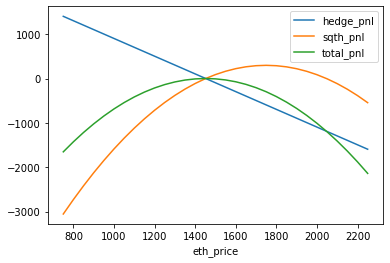

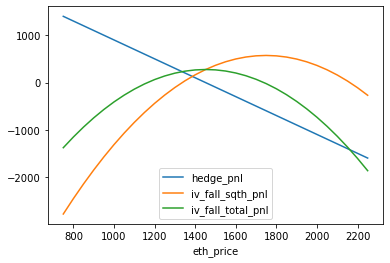

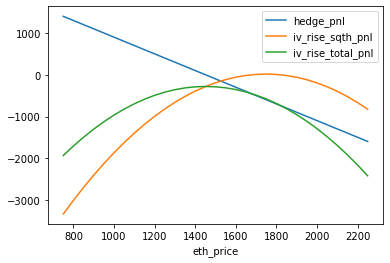

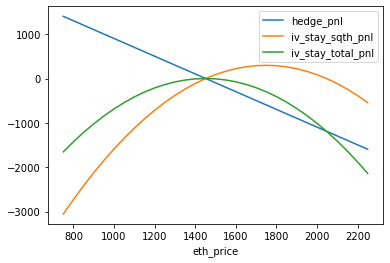

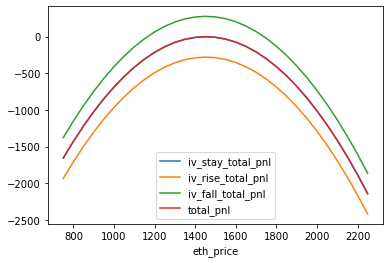

In [155]:
import numpy as np
import pandas as pd

def get_sqth_price_usd_theory(eth_price_usd , iv,norm):
    return norm * (eth_price_usd * eth_price_usd) * math.exp((iv*iv) * FUNDING_PERIOD)/SCALING_FACTOR

def get_sqth_price_eth(eth_price_usd, sqth_price_usd_theory):
    return sqth_price_usd_theory/eth_price_usd

def get_delta(sqth_price_eth):
    return 2 * sqth_price_eth

def get_gamma(sqth_price_eth, eth_price_usd):
    return 2 * sqth_price_eth/ eth_price_usd

def get_vega(iv, sqth_price_usd_theory):
    return 2*iv*FUNDING_PERIOD *sqth_price_usd_theory

def get_theta(iv, sqth_price_usd_theory):
    return iv*iv * sqth_price_usd_theory


iv = 1.03
sim = pd.DataFrame()

sim["eth_price"] = pd.Series(list(range(750,2300,50)))

sim["sqth_usd"] = sim.apply(lambda x: get_sqth_price_usd_theory(x['eth_price'], iv,normalisation_factor), axis=1)
sim["sqth_eth"] = sim.apply(lambda x: get_sqth_price_eth(x['eth_price'], x['sqth_usd']), axis=1)


# greeks 
sim["sqth_gamma"] = sim.apply(lambda x:   sqth_tendered*get_gamma(x["sqth_eth"],x["eth_price"]), axis=1)
sim["sqth_delta"] = sim.apply(lambda x:   sqth_tendered*get_delta(x["sqth_eth"]), axis=1)
sim["sqth_vega"] = sim.apply(lambda x:   sqth_tendered*get_vega(iv,x["sqth_usd"]), axis=1)
sim["sqth_theta"] = sim.apply(lambda x:   sqth_tendered*-get_theta(iv,x["sqth_usd"]), axis=1)

sim["dS"] = sim["eth_price"] - eth_price
seven_day = 7

sim["sqth_pnl"] = pending_delta * sim["dS"] + 0.5*gamma * sqth_tendered * sim["dS"]* sim["dS"]
sim["hedge_pnl"] = -(pending_delta) * sim["dS"] 
sim["total_pnl"] = sim["sqth_pnl"] + sim["hedge_pnl"]
ax = sim.plot(x= "eth_price", y = ["hedge_pnl", "sqth_pnl","total_pnl"])

iv_fall= -0.4
# if iv fall 
sim["iv_fall_sqth_pnl"] = pending_delta * sim["dS"] + 0.5*gamma * sqth_tendered * sim["dS"]* sim["dS"]\
                                + pending_vega*iv_fall 
sim["iv_fall_total_pnl"] = sim["iv_fall_sqth_pnl"] + sim["hedge_pnl"]
sim.plot(x= "eth_price", y = ["hedge_pnl", "iv_fall_sqth_pnl","iv_fall_total_pnl"])

iv_rise = 0.4
# if iv rise
sim["iv_rise_sqth_pnl"] = pending_delta * sim["dS"] + 0.5*gamma * sqth_tendered * sim["dS"]* sim["dS"]\
                                + pending_vega*iv_rise 
sim["iv_rise_total_pnl"] = sim["iv_rise_sqth_pnl"] + sim["hedge_pnl"]
sim.plot(x= "eth_price", y = ["hedge_pnl", "iv_rise_sqth_pnl","iv_rise_total_pnl"])

# if iv doesnt move
sim["iv_stay_sqth_pnl"] = pending_delta * sim["dS"] + 0.5*gamma * sqth_tendered * sim["dS"]* sim["dS"] \
                            
sim["iv_stay_total_pnl"] = sim["iv_stay_sqth_pnl"] + sim["hedge_pnl"]
sim.plot(x= "eth_price", y = ["hedge_pnl", "iv_stay_sqth_pnl","iv_stay_total_pnl"])

sim.plot(x= "eth_price", y = ["iv_stay_total_pnl", "iv_rise_total_pnl","iv_fall_total_pnl","total_pnl"])



## Short vol 

now we have a gauge on the pnl, we can try on some historical data and define a delta hedging band and see how the pnl will looks like

Data were pull from Tardis and we will use index price as as a measurement of current ETH price, norm pulled from event log

In [357]:
hedging_band = 1

df = pd.read_csv(f"event_log_eth_price.csv")
df["norm"] = df["norm"]/10**18
df["sqth_usd"] = df.apply(lambda x: get_sqth_price_usd_theory(x['eth_price'], iv,x["norm"]), axis=1)
df["sqth_eth"] = df.apply(lambda x: get_sqth_price_eth(x['eth_price'], x['sqth_usd']), axis=1)
df["sqth_delta"] = df.apply(lambda x:   sqth_tendered*get_delta(x["sqth_eth"] ), axis=1)
df.loc[0,"net_position"] = -(df.loc[0,"sqth_delta"] + eth_collateral)
df.loc[0,"total_delta"] = df.loc[0,"sqth_delta"] + eth_collateral
df["avg_open_price"] = df.loc[0,"eth_price"]
df["realised_pnl"] = 0
df["iv"] = 0
df["c"] = 0
df.loc[0,"position_changes"] = -(df.loc[0,"sqth_delta"] + eth_collateral)
df["eth_collateral"] = eth_collateral


In [426]:
def calc_hedge(arr_i, arr_last_i , prefix ,hedging_band):
    if arr_i[d[f"{prefix}total_delta"]] > hedging_band:
        # sell
        arr_i[d[f"{prefix}position_changes"]] = -arr_i[d[f"{prefix}total_delta"]]
        # change from long to short
        if arr_i[d[f"{prefix}net_position"]] > 0 : 
            arr_i[d[f"{prefix}realised_pnl"]] = arr_last_i[d[f"{prefix}realised_pnl"]] \
                    + ( arr_i[d[f"{prefix}total_delta"]] * arr_last_i[d[f"{prefix}avg_open_price"]])\
                    - arr_i[d["eth_price"]] * arr_i[d[f"{prefix}total_delta"]]
            
            arr_i[d[f"{prefix}avg_open_price"]] = \
                (arr_last_i[d[f"{prefix}avg_open_price"]] *arr_last_i[d[f"{prefix}net_position"]] \
                            - arr_i[d["eth_price"]] * arr_i[d[f"{prefix}total_delta"]])\
                            / (arr_last_i[d[f"{prefix}net_position"]] - arr_i[d[f"{prefix}total_delta"]])

        # kept shorting
        else:
            arr_i[d[f"{prefix}avg_open_price"]] = \
                (arr_last_i[d[f"{prefix}avg_open_price"]] *arr_last_i[d[f"{prefix}net_position"]] \
                            + arr_i[d["eth_price"]] * -arr_i[d[f"{prefix}total_delta"]])\
                            / (arr_last_i[d[f"{prefix}net_position"]] - arr_i[d[f"{prefix}total_delta"]])
            
            arr_i[d[f"{prefix}realised_pnl"]] = arr_last_i[d[f"{prefix}realised_pnl"]]
            
        arr_i[d[f"{prefix}iv"]] = arr_i[d["c"]]

    elif arr_i[d[f"{prefix}total_delta"]] < -hedging_band:
        # buy 

        arr_i[d[f"{prefix}position_changes"]] = -arr_i[d[f"{prefix}total_delta"]]
        
        if arr_i[d[f"{prefix}net_position"]] < 0 : 
            
            arr_i[d[f"{prefix}realised_pnl"]] = \
                arr_last_i[d[f"{prefix}realised_pnl"]] \
            + (-arr_i[d[f"{prefix}total_delta"]] * arr_last_i[d[f"{prefix}avg_open_price"]])\
            - arr_i[d["eth_price"]] * -arr_i[d[f"{prefix}total_delta"]]
  
            
            arr_i[d[f"{prefix}avg_open_price"]] = \
                (arr_last_i[d[f"{prefix}avg_open_price"]] *-arr_last_i[d[f"{prefix}net_position"]] \
                            - arr_i[d["eth_price"]] * -arr_i[d[f"{prefix}total_delta"]])\
                            / (-arr_last_i[d[f"{prefix}net_position"]] - -arr_i[d[f"{prefix}total_delta"]])

        else:
            arr_i[d[f"{prefix}avg_open_price"]] = \
                (arr_last_i[d[f"{prefix}avg_open_price"]] * arr_last_i[d[f"{prefix}net_position"]]\
                + arr_i[d["eth_price"]] * -arr_i[d[f"{prefix}total_delta"]])\
                / (arr_last_i[d[f"{prefix}net_position"]] - arr_i[d[f"{prefix}total_delta"]])
            
                  
            arr_i[d[f"{prefix}realised_pnl"]] = arr_last_i[d[f"{prefix}realised_pnl"]]
            
        arr_i[d[f"{prefix}iv"]] = arr_i[d["c"]]
    else:
        arr_i[d[f"{prefix}avg_open_price"]] = arr_last_i[d[f"{prefix}avg_open_price"]]
        arr_i[d[f"{prefix}realised_pnl"]] = arr_last_i[d[f"{prefix}realised_pnl"]]
        arr_i[d[f"{prefix}position_changes"]] =0
        arr_i[d[f"{prefix}iv"]] = arr_last_i[d[f"{prefix}iv"]]
        
    arr_i[d[f"{prefix}net_position"]] =  \
            arr_i[d[f"{prefix}position_changes"]] + arr_last_i[d[f"{prefix}net_position"]]

In [379]:
arr =df.to_numpy()
d = {}
for c in df.columns:
    d[c] = df.columns.get_loc(c)
for i in range(1,len(arr)):
    arr[i][d["total_delta"]] = arr[i][d["sqth_delta"]] + arr[i-1][d["net_position"]] + arr[i][d["eth_collateral"]]
    calc_hedge(arr[i], arr[i-1], "", hedging_band)

df = pd.DataFrame(arr, columns=df.columns)
df["unrealised_pnl"] = (df["eth_price"] - df["avg_open_price"]  ) * df["net_position"]



<AxesSubplot:label='3deb871c-3638-4434-acee-ee6f54631e9d'>

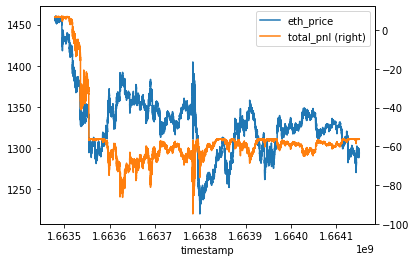

In [380]:

earliest_ts = df["timestamp"].min()
df["dS"] = df["eth_price"] - eth_price
df["sqth_pnl"] = delta * sqth_tendered * df["dS"] + 0.5*gamma * sqth_tendered * df["dS"]* df["dS"]\

df["collateral_pnl"] = df["eth_collateral"] * df["dS"]
df["hedge_pnl"] = df["unrealised_pnl"] + df["realised_pnl"]
df["total_pnl"] = df["sqth_pnl"] + df["hedge_pnl"] + df["collateral_pnl"]

ax = df.plot(x="timestamp",y = "eth_price")
df.plot(x= "timestamp", y = ["total_pnl"],secondary_y=True,ax=ax)

## IV
Delta hedge seems not enough to cover the pnl, when normalisation factor move. SQTH is a long/short vol strategy, which means when normalisation factor changes (when someone mint/burn their token) there is a change in IV.

we use dvol from deribit and perform delta hedge again. 

In [362]:
df_iv = pd.read_csv(f"event_log_price_iv.csv")
df_iv["norm"] = df_iv["norm"]/10**18
df_iv["c"] = df_iv["c"]/100
df_iv["iv"] = 0
df_iv["sqth_usd"] = df_iv.apply(lambda x: get_sqth_price_usd_theory(x['eth_price'], x["c"],x["norm"]), axis=1)
df_iv["sqth_eth"] = df_iv.apply(lambda x: get_sqth_price_eth(x['eth_price'], x['sqth_usd']), axis=1)
df_iv["sqth_delta"] = df_iv.apply(lambda x:   sqth_tendered*get_delta(x["sqth_eth"] ), axis=1)
df_iv.loc[0,"net_position"] = -(df_iv.loc[0,"sqth_delta"] + eth_collateral)
df_iv.loc[0,"total_delta"] = df_iv.loc[0,"sqth_delta"] + eth_collateral
df_iv["avg_open_price"] = df_iv.loc[0,"eth_price"]
df_iv["realised_pnl"] = 0
df_iv.loc[0,"position_changes"] = -(df_iv.loc[0,"sqth_delta"] + eth_collateral)
df_iv["eth_collateral"] = eth_collateral


In [364]:

arr =df_iv.to_numpy()
d = {}
for c in df_iv.columns:
    d[c] = df_iv.columns.get_loc(c)
for i in range(1,len(arr)):
    arr[i][d["total_delta"]] = arr[i][d["sqth_delta"]] + arr[i-1][d["net_position"]] + arr[i][d["eth_collateral"]]
    calc_hedge(arr[i], arr[i-1] , "" ,hedging_band)

df_iv = pd.DataFrame(arr, columns=df_iv.columns)
df_iv["unrealised_pnl"] = (df_iv["eth_price"] - df_iv["avg_open_price"]  ) * df_iv["net_position"]

<AxesSubplot:label='407a079f-603f-41c3-bf16-893ca99f2a3c'>

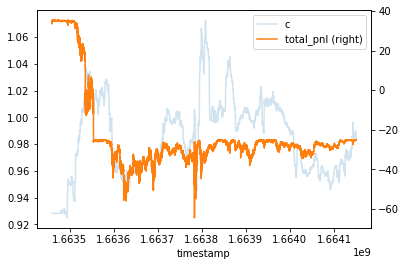

In [365]:
df_iv["dS"] = df_iv["eth_price"] - eth_price
df_iv["sqth_pnl"] = delta * sqth_tendered * df_iv["dS"] + 0.5*gamma * sqth_tendered * df_iv["dS"]* df_iv["dS"]\

df_iv["collateral_pnl"] = df_iv["eth_collateral"] * df_iv["dS"]
df_iv["hedge_pnl"] = df_iv["unrealised_pnl"] + df_iv["realised_pnl"]
df_iv["total_pnl"] = df_iv["sqth_pnl"] + df_iv["hedge_pnl"] + df_iv["collateral_pnl"]

ax = df_iv.plot(x="timestamp",y = "c",alpha = 0.2)
df_iv.plot(x= "timestamp", y = ["total_pnl"],secondary_y=True,ax=ax)

we seem still losing. 

## IV  impact on delta
find out vanna of holding one sqth, as this would be how much we need to short,
Vanna is $\frac{\partial \kappa}{\partial S}$ or $\frac{\partial \Delta}{\partial V}$ in other words, DvegaDspot or DdeltaDvol,

$\frac{d\Delta}{dV} = \frac{\partial \kappa}{\partial S} = 4\cdot S \cdot t \cdot v \cdot e^{t \cdot  v^2}\cdot \frac{norm}{10000} $

In [382]:

def get_vanna(eth_price,iv):
    return 4* eth_price * FUNDING_PERIOD * iv * \
                              math.exp(FUNDING_PERIOD * iv*iv)*normalisation_factor / SCALING_FACTOR
vanna = get_vanna(eth_price,iv)
sum_vanna = sqth_tendered * vanna 
print("vanna (every 1% change in iv, delta change by / every 1$ change in ETH, vega change by): ", vanna)
print("sum of vanna we holding (sqth) : ", sum_vanna)

# make adjustment on hedge


df_iv_vanna = pd.read_csv(f"event_log_price_iv.csv")
df_iv_vanna["norm"] = df_iv_vanna["norm"]/10**18
df_iv_vanna["c"] = df_iv_vanna["c"]/100
df_iv_vanna["sqth_vanna"] = df_iv_vanna.apply(lambda x : sqth_tendered*get_vanna(x["eth_price"],x["c"]),axis=1)
df_iv_vanna["sqth_usd"] = df_iv_vanna.apply(lambda x: get_sqth_price_usd_theory(x['eth_price'], x["c"],x["norm"]), axis=1)
df_iv_vanna["sqth_eth"] = df_iv_vanna.apply(lambda x: get_sqth_price_eth(x['eth_price'], x['sqth_usd']), axis=1)
df_iv_vanna["sqth_delta"] = df_iv_vanna.apply(lambda x:   sqth_tendered*get_delta(x["sqth_eth"] ), axis=1)
df_iv_vanna.loc[0,"net_position"] = -(df_iv_vanna.loc[0,"sqth_delta"] + eth_collateral)
df_iv_vanna.loc[0,"total_delta"] = df_iv_vanna.loc[0,"sqth_delta"] + eth_collateral - df_iv_vanna.loc[0,"sqth_vanna"]
df_iv_vanna.loc[0,"iv"] = df_iv_vanna.loc[0,"c"]
df_iv_vanna["dIV"] = 0 
df_iv_vanna["avg_open_price"] = df_iv_vanna.loc[0,"eth_price"]
df_iv_vanna["realised_pnl"] = 0
df_iv_vanna.loc[0,"position_changes"] = -df_iv_vanna.loc[0,"total_delta"]
df_iv_vanna["eth_collateral"] = eth_collateral


vanna (every 1% change in iv, delta change by / every 1$ change in ETH, vega change by):  0.013617850779710852
sum of vanna we holding (sqth) :  -0.9571904348652597


In [383]:
arr =df_iv_vanna.to_numpy()
d = {}
iv_band = 0.01
for c in df_iv_vanna.columns:
    d[c] = df_iv_vanna.columns.get_loc(c)
for i in range(1,len(arr)):   
    arr[i][d["dIV"]] = arr[i-1][d["iv"]] - arr[i][d["c"]]
    arr[i][d["total_delta"]] = arr[i][d["sqth_delta"]] + arr[i-1][d["net_position"]] \
                            + arr[i][d["eth_collateral"]] \
                            + (arr[i][d["dIV"]]) *(arr[i][d["sqth_vanna"]])        
    calc_hedge(arr[i], arr[i-1], "", hedging_band)

df_iv_vanna = pd.DataFrame(arr, columns=df_iv_vanna.columns)
df_iv_vanna["unrealised_pnl"] = (df_iv_vanna["eth_price"] - df_iv_vanna["avg_open_price"]) \
                                * df_iv_vanna["net_position"]


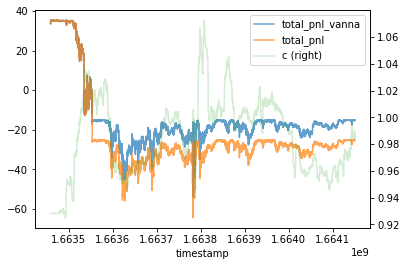

In [384]:
df_iv_vanna["dS"] = df_iv_vanna["eth_price"] - eth_price
df_iv_vanna["sqth_pnl"] = delta * sqth_tendered * df_iv_vanna["dS"] + 0.5*gamma * sqth_tendered \
                        * df_iv_vanna["dS"]* df_iv_vanna["dS"] \

    
df_iv_vanna["collateral_pnl"] = df_iv_vanna["eth_collateral"] * df_iv_vanna["dS"]
df_iv_vanna["hedge_pnl"] = df_iv_vanna["unrealised_pnl"] + df_iv_vanna["realised_pnl"]
df_iv_vanna["total_pnl_vanna"] = df_iv_vanna["sqth_pnl"] + df_iv_vanna["hedge_pnl"] + df_iv_vanna["collateral_pnl"]

ax = df_iv_vanna.plot(x="timestamp",y = "total_pnl_vanna",alpha=0.7)

ax = df_iv.plot(x= "timestamp", y = ["total_pnl"],ax=ax,alpha=0.7)
ax = df_iv_vanna.plot(x="timestamp",y = "c",secondary_y=True,ax=ax,alpha=0.2)


### We now have reduced our loss by hedging with both delta and vanna, but we only be using perps so far, can we do it with option?

## Short vol short delta
In the previous section we covered how important IV is, we look into how option and spot market correlation before going into hedging.

### Spot Vol correlation
we know that when spot increases vol decrese, spot decrese vol increase.
as spot price goes up, investor will be happy and not buygin any option, but when price drop, investor tends to buy option as a protection to downside risk. 

we can see the negative correlation from image below from genesis vol https://pro.gvol.io/dvol-index/eth. This would help in the hedging later if we know the $P(dETH | div ) $ , where we may not need to hedge all delta.

iv| Price     | sqth        | hedge       | option (- delta)
--|:---------:|:-----------:|:-----------:|:-----------:
- | -      | + | + | +      
- | +      | + | - | - 
+ | -      | - | + | + 
+ | +      | - | - | -


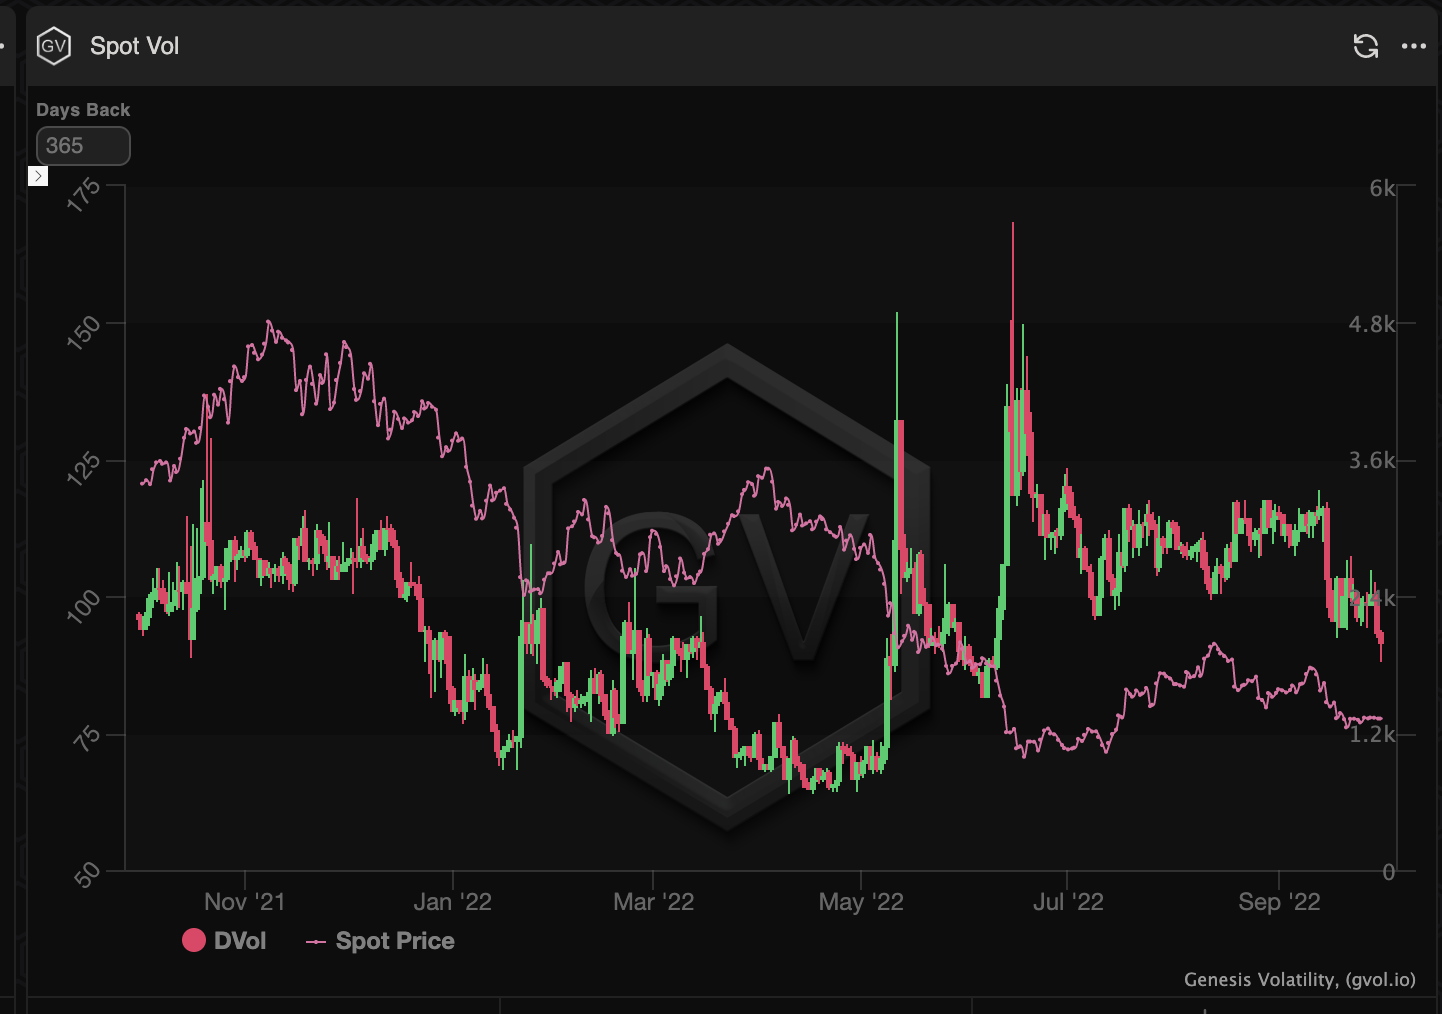

### Long Put

We go long put with the delta we have at beginning and adjust hedge with sqth vanna

$$
\Delta_{sqth} + k \cdot \Delta_{option} = 0
$$
$$
k  = \frac{-\Delta_{sqth}} {\Delta_{option}}
$$


In [385]:
df_long_put = pd.read_csv(f"event_log_price_iv.csv")
df_long_put["norm"] = df_long_put["norm"]/10**18
df_long_put["c"] = df_long_put["c"]/100


In [386]:
# expected_move = eth_price * iv * math.sqrt(seven_day/365)

option_tick = 50 
latest_ts = df_long_put["timestamp"].max()

atm_put_strike = nearest_strike(eth_price, option_tick)
print("ATM Strike: ",atm_put_strike)

df_long_put["sqth_usd"] = df_long_put.apply(lambda x: get_sqth_price_usd_theory(x['eth_price'], x["c"],x["norm"]), axis=1)
df_long_put["sqth_eth"] = df_long_put.apply(lambda x: get_sqth_price_eth(x['eth_price'], x['sqth_usd']), axis=1)
df_long_put["sqth_delta"] = df_long_put.apply(lambda x:   sqth_tendered*get_delta(x["sqth_eth"] ), axis=1)
df_long_put["sqth_vanna"] = df_long_put.apply(lambda x : sqth_tendered*get_vanna(x["eth_price"],x["c"]),axis=1)
df_long_put["eth_collateral"] = eth_collateral

entry_iv = df_long_put.loc[0,"c"]
entry_eth_price = df_long_put.loc[0,"eth_price"]
DTE = (latest_ts-df_long_put.loc[0,"timestamp"]) /86400/365

atm_k = -(pending_delta) / put_delta(entry_eth_price,\
                                        atm_put_strike, DTE,interest_rate,entry_iv)

df_long_put["DTE"] = (latest_ts-df_long_put["timestamp"]) /86400/365

df_long_put["atm_delta"] = df_long_put.apply(lambda x: atm_k* put_delta(x["eth_price"],\
                                        atm_put_strike,x["DTE"] ,interest_rate,x["c"]) , axis=1)

df_long_put["atm_avg_open_price"] = 0
df_long_put["atm_realised_pnl"] = 0
df_long_put["atm_unrealised_pnl"] = 0
df_long_put["atm_net_position"] = 0
df_long_put["atm_total_delta"] = 0
df_long_put["atm_iv"] = 0
df_long_put["atm_dIV"] = 0
df_long_put["atm_position_changes"] = 0

atm_prem =  bs_put(entry_eth_price, atm_put_strike, DTE , interest_rate,entry_iv)

ATM Strike:  1450


<ipython-input-196-3ddd1115811d>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))


In [387]:
arr =df_long_put.to_numpy()
d = {}

for c in df_long_put.columns:
    d[c] = df_long_put.columns.get_loc(c)
    
def profit_calc(arr_i, arr_last_i, prefix):
    arr_i[d[f"{prefix}dIV"]] = arr_last_i[d[f"{prefix}iv"]] - arr_i[d["c"]]
    arr_i[d[f"{prefix}total_delta"]] = arr_i[d["sqth_delta"]] + arr_last_i[d[f"{prefix}net_position"]] \
                            + arr_i[d["eth_collateral"]] \
                            + (arr_i[d[f"{prefix}dIV"]]) * (arr_i[d["sqth_vanna"]])\
                            + (arr_i[d[f"{prefix}delta"]]) 
    calc_hedge(arr[i], arr[i-1], prefix, hedging_band)
    
for i in range(1,len(arr)):   
    profit_calc(arr[i],arr[i-1],"atm_")

df_long_put = pd.DataFrame(arr, columns=df_long_put.columns)


In [388]:

df_long_put["atm_prem_ts"] = df_long_put.apply(lambda x : bs_put(x["eth_price"], \
                                                atm_put_strike, x["DTE"] , interest_rate,x["c"]),axis=1)

df_long_put["atm_pnl"] =    (df_long_put["atm_prem_ts"]-atm_prem ) * atm_k

# df_long_put["atm_pnl"] = df_long_put.apply(lambda x : atm_k* \
#                                            (max(atm_put_strike - x["eth_price"],0) - atm_prem),axis=1)

df_long_put["atm_unrealised_pnl"] = ((df_long_put["eth_price"] - df_long_put["atm_avg_open_price"]) \
                                * df_long_put["atm_net_position"]) + df_long_put["atm_pnl"]


<ipython-input-196-3ddd1115811d>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))


In [434]:
df_long_put["atm_delta"]

0         -1.998270
1         -1.998270
2         -1.998270
3         -1.998270
4         -1.998270
             ...   
1157263   -4.594058
1157264   -4.594058
1157265   -4.594058
1157266   -4.594058
1157267   -4.594058
Name: atm_delta, Length: 1157268, dtype: float64

<AxesSubplot:label='f6dfec7c-36aa-48af-8729-b04e1cf126c7'>

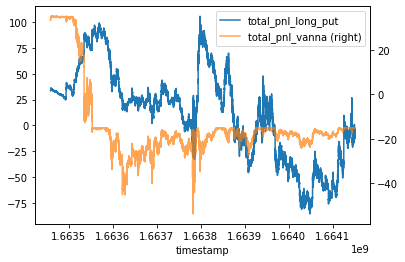

In [393]:

df_long_put["dS"] = df_long_put["eth_price"] - eth_price
df_long_put["sqth_pnl"] = delta * sqth_tendered * df_long_put["dS"] + 0.5*gamma * sqth_tendered \
                        * df_long_put["dS"]* df_long_put["dS"] 
df_long_put["collateral_pnl"] = df_long_put["eth_collateral"] * df_long_put["dS"]
df_long_put["hedge_pnl"] = df_long_put["atm_unrealised_pnl"] + df_long_put["atm_realised_pnl"] 

df_long_put["total_pnl_long_put"] = df_long_put["sqth_pnl"] + df_long_put["hedge_pnl"] + df_long_put["collateral_pnl"]

ax = df_long_put.plot(x="timestamp",y = "total_pnl_long_put")
df_iv_vanna.plot(x= "timestamp", y = ["total_pnl_vanna"],secondary_y=True,ax=ax,alpha=0.7)

<AxesSubplot:label='bc6fc965-2b36-4153-8eeb-b537518ab6d8'>

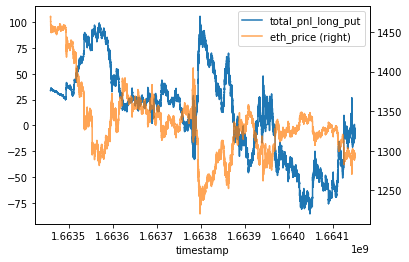

In [394]:
ax = df_long_put.plot(x="timestamp",y = "total_pnl_long_put")
df_long_put.plot(x= "timestamp", y = ["eth_price"],secondary_y=True,ax=ax,alpha=0.7)


notice our pnl for long put is negatively related to eth price, hedging on option introduce more changes in pnl, however hedging with vanna pnl is more flat.

Another thing we missed out here is the dynamic hedging on option. hedging option greeks is not simple as just delta hedging , we have second order derivatives greeks here which allows more possiblities. which we might be able to yield better pnl

### Short call 


In [395]:
df_short_call = pd.read_csv(f"event_log_price_iv.csv")
df_short_call["norm"] = df_short_call["norm"]/10**18
df_short_call["c"] = df_short_call["c"]/100

In [396]:
# expected_move = eth_price * iv * math.sqrt(seven_day/365)

option_tick = 50 

latest_ts = df_short_call["timestamp"].max()
atm_call_strike = nearest_strike(eth_price, option_tick)
print("ATM Strike: ",atm_put_strike)

df_short_call["sqth_usd"] = df_short_call.apply(lambda x: get_sqth_price_usd_theory(x['eth_price'], x["c"],x["norm"]), axis=1)
df_short_call["sqth_eth"] = df_short_call.apply(lambda x: get_sqth_price_eth(x['eth_price'], x['sqth_usd']), axis=1)
df_short_call["sqth_delta"] = df_short_call.apply(lambda x:   sqth_tendered*get_delta(x["sqth_eth"] ), axis=1)
df_short_call["sqth_vanna"] = df_short_call.apply(lambda x : sqth_tendered*get_vanna(x["eth_price"],x["c"]),axis=1)
df_short_call["eth_collateral"] = eth_collateral

entry_iv = df_short_call.loc[0,"c"]
entry_eth_price = df_short_call.loc[0,"eth_price"]
DTE = (latest_ts-df_short_call.loc[0,"timestamp"]) /86400/365

atm_short_call_k = -(pending_delta) / call_delta(entry_eth_price,\
                                        atm_call_strike, DTE,interest_rate,entry_iv)

df_short_call["DTE"] = (latest_ts-df_short_call["timestamp"]) /86400/365

df_short_call["atm_delta"] = df_short_call.apply(lambda x: atm_short_call_k* call_delta(x["eth_price"],\
                                        atm_call_strike,x["DTE"] ,interest_rate,x["c"]) , axis=1)
df_short_call["atm_avg_open_price"] = 0
df_short_call["atm_realised_pnl"] = 0
df_short_call["atm_unrealised_pnl"] = 0
df_short_call["atm_net_position"] = 0
df_short_call["atm_total_delta"] = 0
df_short_call["atm_iv"] = 0
df_short_call["atm_dIV"] = 0
df_short_call["atm_position_changes"] = 0
atm_short_call_prem =  bs_call(entry_eth_price, atm_call_strike, DTE , interest_rate,entry_iv)

ATM Strike:  1450


<ipython-input-196-3ddd1115811d>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))


In [427]:
arr = df_short_call.to_numpy()
d = {}

for c in df_short_call.columns:
    d[c] = df_short_call.columns.get_loc(c)
        
for i in range(1,len(arr)):   
    profit_calc(arr[i],arr[i-1],"atm_")

df_short_call = pd.DataFrame(arr, columns=df_short_call.columns)


In [431]:
df_short_call["atm_prem_ts"] = df_short_call.apply(lambda x :  bs_call(x["eth_price"], \
                                                atm_call_strike, x["DTE"] , interest_rate,x["c"]),axis=1)

df_short_call["atm_pnl"] =  ( df_short_call["atm_prem_ts"] - atm_short_call_prem ) * atm_short_call_k

df_short_call["atm_unrealised_pnl"] = ((df_short_call["eth_price"] - df_short_call["atm_avg_open_price"]) \
                                * df_short_call["atm_net_position"]) + df_short_call["atm_pnl"]

<ipython-input-196-3ddd1115811d>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))


<AxesSubplot:xlabel='timestamp'>

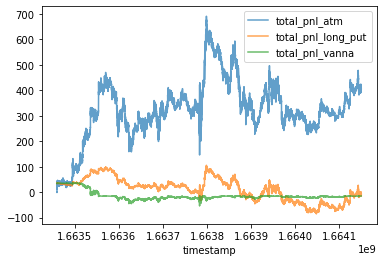

In [430]:
df_short_call["total_pnl_atm"] = df_short_call["atm_unrealised_pnl"] + df_short_call["atm_realised_pnl"] 

ax = df_short_call.plot(x="timestamp",y = "total_pnl_atm",alpha=0.7)
ax = df_long_put.plot(x="timestamp",y = "total_pnl_long_put", ax = ax , alpha=0.7)
df_iv_vanna.plot(x= "timestamp", y = ["total_pnl_vanna"],ax=ax,alpha=0.7)

short call yields more pnl since , 

when a short call become ITM , delta is close to 0,long put become ITM , delta is close to -1. Hence the discrepency of hedging, when we long put, we didnt hedge, while it comes to short call we hedge a few times (both directional)



## Conclusion : 
Rebalance Vault 

    Aim : can be Short SQTH or Long SQTH
    
    Hedging :
    
        Uniswap V3 :
            Open Market Arbitrage : 
                Take note on the function (hedgeOnUniswap ), it allows us to hedge directly to uniswap but only success when open market provides enough liquidity. Otherwise we need our own impl to hedge as much.
                Uniswap V3, and find the trade as much as possible
                
        Option:
            Delta Changes over time (charm), iv (vanna) and price (gamma), we will need dynamic hedging on this to yield better pnl
            
            Short SQTH:
                Long Put : 
                    unlimited downside profit , limited upside risk
                Short Call:
                    limited downside profit, unlimited upside risk
            Long SQTH (not covered in here but the idea is similar):
                Long Call : 
                    limited downside risk , unlimited upside profit
                Short Put:
                    unlimited downside risk, limited upside profit



## Further improvment : 
1) Find probablity of P(dETH| dIV ), adjust pnl accordingly & hedge improvement

2) back test w historical options data & calculate market impact if possible, especially when size is big, market impact can hurt. 

    We make the assumption where the pricing follows BS model while it might not be true also when executing in    deribit the option is settle in coin not usd value.

3) Hedging:

    we should also adjust our hedge frequency according to SQTH charm $\frac{\partial \Delta}{\partial \theta}$,    aka DdeltaDtheta
    
    Options wise, we can do better with more robust hedging wrt gamma/ vega/ vanna / charm.
    
    Vanna for option 

    Long call || short put ,  positive vanna 

    long put || short call, negative vanna 
    
3) Vault greeks & next rebalancing
    
    We covered if we rebalance the vault and hold for a certain period, however in practical we can rebalance the  vault daily / price threshold met. This could change our portfolio in different way.
  
4) Greeks profile and impact to pnl
    
    We should include a detailed pnl by both option and sqth greeks and find out where our real pnl comes from. with that we improve our hedging 

## Thanks!


In [ ]:
# vault greeks wrt to eth price 
def get_auction_details(sqth_holding,eth_delta, eth_price_usd):
    sqth_usd = get_sqth_price_usd_theory(eth_price_usd , iv,normalisation_factor)
    current_sqth_eth_price = get_sqth_price_eth(eth_price_usd, sqth_usd) * 10**18
    (is_selling, target)= check_auction_type(sqth_holding,eth_delta, current_sqth_eth_price)
    if target ==0:
        return 
    auction_price = get_auction_price(current_sqth_eth_price, is_selling)
    (is_still_selling, sqth_to_auc) = check_auction_type(sqth_holding,eth_delta, auction_price)
    eth_proceed = sqth_to_auc*(auction_price)
    
    return (is_selling, sqth_to_auc, eth_proceed, auction_price)

def check_auction_type(debt, eth_delta, sqth_eth_price):
    sqth_delta = debt*2e18 * sqth_eth_price

    targetHedge,  isSellingAuction = get_target_hedge_auction_type(
        sqth_delta,
        eth_delta,
        sqth_eth_price)
    
    if target_hedge * sqth_eth_price / eth_delta  > DELTA_HEDGE_THRESHOLD: 
        return (isSellingAuction, targetHedge)
    return (False, 0)
def get_target_hedge_auction_type(sqth_delta, eth_delta, sqth_eth_price):
    if (sqth_delta > eth_delta):
        return((sqth_delta- (eth_delta))/sqth_eth_price, False)
    return ((eth_delta-sqth_delta)/sqth_eth_price, True)

def get_auction_price(sqth_eth_price, is_selling):
    ratio = 0
    diff = MAX_PRICE_MULT- MIN_PRICE_MULT
    if (is_selling):
        price_multiplier = MAX_PRICE_MULT - ratio*diff
    else :
        price_multiplier = MIN_PRICE_MULT + ratio*diff
    return sqth_eth_price*(price_multiplier)
print("Crab Debt in SQTH : ",sqth_holding)
print("Crab Collateral : ", eth_delta)

